# Assignment 3


# Data Preparation


### Needed imports


In [1]:
import pandas as pd
import os
# from datetime import datetime
# import re # regex support
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import json
from sklearn.cluster import MeanShift, estimate_bandwidth, Birch
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score


### Data gathering


In [2]:
data_pathname = os.path.join(os.getcwd(), "data")
results_pathname = os.path.join(os.getcwd(), "results")
filename_citibike = "2015-citibike_tripdata_combined.csv"
filename_citibike_sample = "2015-citibike_tripdata_combined_sample.csv"
filename_weather = "weather_data_nyc.csv"
encoding_type = "utf-8"

# Change this flag if you want to use the full data set (~1,7gb). Warning: This will change the runtime significantly
use_sample_data = True


In [3]:
df_citibike = pd.DataFrame()
if use_sample_data:
    df_citibike = pd.read_csv(os.path.join(
        data_pathname, filename_citibike_sample), encoding=encoding_type)
else:
    df_citibike = pd.read_csv(os.path.join(
        data_pathname, filename_citibike), encoding=encoding_type)

df_weather = pd.read_csv(os.path.join(
    data_pathname, filename_weather), encoding=encoding_type)


# ETL Citibike dataset


In [4]:
print(f"Citibike DataFrame length: {len(df_citibike)}")
print(f"Show first and last rows of Citibike:")
df_citibike.iloc[[1, -1]]


Citibike DataFrame length: 99380
Show first and last rows of Citibike:


Unnamed: 0  tripduration            starttime             stoptime  \
1         1043212          1542   4/13/2015 08:07:06   4/13/2015 08:32:48   
99379     8672150           418  11/14/2015 15:39:48  11/14/2015 15:46:46   

       start station id start station name  start station latitude  \
1                   545    E 23 St & 1 Ave               40.736502   
99379               317  E 6 St & Avenue B               40.724537   

       start station longitude  end station id           end station name  \
1                   -73.978095             415  Pearl St & Hanover Square   
99379               -73.981854             301          E 2 St & Avenue B   

       end station latitude  end station longitude  bikeid    usertype  \
1                 40.704718             -74.009260   19785  Subscriber   
99379             40.722174             -73.983688   19774  Subscriber   

       birth year  gender  
1          1957.0       1  
99379      1961.0       1

In [5]:
print("Citibike DataFrame data types per column (auto import):")
print(f"{df_citibike.dtypes}")


Citibike DataFrame data types per column (auto import):
Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object


### Renaming


In [6]:
df_citibike.rename(columns={"Unnamed: 0": "uniqueid"}, inplace=True)


In [7]:
df_citibike.rename(columns={"start station id": "start_station_id",
                            "start station name": "start_station_name",
                            "start station latitude": "start_station_latitude",
                            "start station longitude": "start_station_longitude",
                            "end station id": "end_station_id",
                            "end station name": "end_station_name",
                            "end station latitude": "end_station_latitude",
                            "end station longitude": "end_station_longitude",
                            "birth year": "birth_year"}, inplace=True)


### Type Conversion


In [8]:
# Some missing seconds values
print("Convert column starttime and stoptime from object to datetime")
df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'], format="%m/%d/%Y %H:%M:%S", errors="coerce").fillna(
    pd.to_datetime(df_citibike['starttime'], format="%m/%d/%Y %H:%M", errors="coerce"))
df_citibike['stoptime'] = pd.to_datetime(df_citibike['stoptime'], format="%m/%d/%Y %H:%M:%S", errors="coerce").fillna(
    pd.to_datetime(df_citibike['stoptime'], format="%m/%d/%Y %H:%M", errors="coerce"))
print(
    f"Example after conversion: {df_citibike['stoptime'][42]} with type {df_citibike['stoptime'].dtype}")


Convert column starttime and stoptime from object to datetime
Example after conversion: 2015-06-30 17:59:00 with type datetime64[ns]


In [9]:
print("Checking for categorial values in the columns")
for column in df_citibike.columns:
    print(
        f"Column {column} has {df_citibike[column].value_counts().count()} distinct values")


Checking for categorial values in the columns
Column uniqueid has 99380 distinct values
Column tripduration has 4294 distinct values
Column starttime has 97028 distinct values
Column stoptime has 97046 distinct values
Column start_station_id has 485 distinct values
Column start_station_name has 494 distinct values
Column start_station_latitude has 507 distinct values
Column start_station_longitude has 507 distinct values
Column end_station_id has 488 distinct values
Column end_station_name has 497 distinct values
Column end_station_latitude has 510 distinct values
Column end_station_longitude has 510 distinct values
Column bikeid has 8348 distinct values
Column usertype has 2 distinct values
Column birth_year has 77 distinct values
Column gender has 3 distinct values


In [10]:
print("Convert to categorial variables")
df_citibike["start_station_id"] = df_citibike["start_station_id"].astype(
    "category")
df_citibike["end_station_id"] = df_citibike["end_station_id"].astype(
    "category")
df_citibike["usertype"] = df_citibike["usertype"].astype("category")
df_citibike["gender"] = df_citibike["gender"].replace(
    {0: "unknown", 1: "male", 2: "female"}).astype("category")


Convert to categorial variables


In [11]:
print("Convert birth_year to Integer")
df_citibike["birth_year"] = df_citibike["birth_year"].astype(
    "Int64")  # Int64Dtype can handle NaN values compared to int64


Convert birth_year to Integer


### Creating a date column


In [12]:
df_citibike["Date"] = pd.to_datetime(df_citibike["starttime"].dt.date)


### Detect and handle outliers


Check tripduration values for outliers


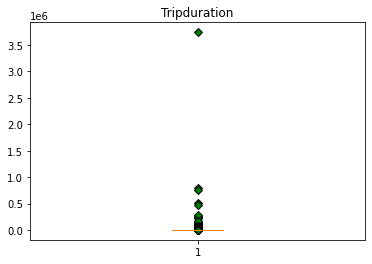

In [13]:
print("Check tripduration values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Tripduration')
bp = ax1.boxplot(df_citibike['tripduration'], flierprops=green_diamond)
plt.show()


In [14]:
for key in bp:
    print(f'{key}: {[item.get_ydata() for item in bp[key]]}\n')


whiskers: [array([388.,  60.]), array([1050., 2043.])]

caps: [array([60, 60], dtype=int64), array([2043, 2043], dtype=int64)]

boxes: [array([ 388.,  388., 1050., 1050.,  388.])]

medians: [array([627., 627.])]

fliers: [array([6033, 2126, 2819, ..., 2630, 2199, 2175], dtype=int64)]

means: []



In [15]:
fliers = [item.get_ydata() for item in bp['fliers']]

q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]

lower_outliers = []
upper_outliers = []

for i in range(len(fliers)):
    lower_outliers_by_box = []
    upper_outliers_by_box = []
    for outlier in fliers[i]:
        if outlier < q1[i]:
            lower_outliers_by_box.append(round(outlier, 1))
        else:
            upper_outliers_by_box.append(round(outlier, 1))

    # storing outliers
    lower_outliers.append(lower_outliers_by_box)
    upper_outliers.append(upper_outliers_by_box)

print(f'Lower outliers: {len(lower_outliers_by_box)}\n'
      f'Upper outliers: {len(upper_outliers_by_box)}')


Lower outliers: 0
Upper outliers: 4803


Finding a resonable tripduration limit:


NYC Area = 789,4 km²


d=root(4A/π)


In [16]:
# NYC Area
import math
nycArea = 789400  # km²

dOfNYC = math.sqrt(4*nycArea/math.pi)*2

print(f"{dOfNYC} km")


2005.0888225851118 km


In [17]:
limit = dOfNYC
column_name = 'tripduration'

column = df_citibike[column_name]

count = column[column > limit].count()

print(f"{count}")


5085


In [18]:
df_citibike_clean = df_citibike[df_citibike.tripduration <= dOfNYC]


New Chart after Outlyers have been handled


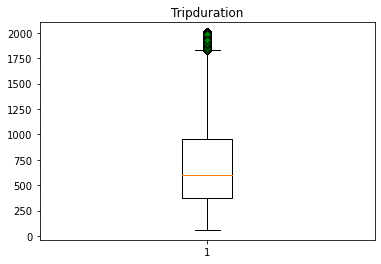

In [19]:
print("New Chart after Outlyers have been handled")
green_diamond = dict(markerfacecolor='g', marker='D')
fig2, ax2 = plt.subplots()
ax2.set_title('Tripduration')
bp = ax2.boxplot(df_citibike_clean['tripduration'], flierprops=green_diamond)
plt.show()


### Final Checks


In [20]:
print("Check for missing values in Citibike:")
df_citibike_clean.isna().sum()


Check for missing values in Citibike:


uniqueid                       0
tripduration                   0
starttime                      0
stoptime                       0
start_station_id               0
start_station_name             0
start_station_latitude         0
start_station_longitude        0
end_station_id                 0
end_station_name               0
end_station_latitude           0
end_station_longitude          0
bikeid                         0
usertype                       0
birth_year                 10678
gender                         0
Date                           0
dtype: int64

Since there are only values missing in the birth year, we decided to keep them in and use a later learned ml algorithm to try to guess the age (knn or other techniques)


In [21]:
print("Final Citibike DataFrame data types per column:")
print(f"{df_citibike_clean.dtypes}")


Final Citibike DataFrame data types per column:
uniqueid                            int64
tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                 category
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                   category
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                         category
birth_year                          Int64
gender                           category
Date                       datetime64[ns]
dtype: object


In [22]:
print("Final cleaned citibike dataset (first and last row):")
df_citibike_clean.iloc[[1, -1]]


Final cleaned citibike dataset (first and last row):


uniqueid  tripduration           starttime            stoptime  \
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
99379   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id start_station_name  start_station_latitude  \
1                  545    E 23 St & 1 Ave               40.736502   
99379              317  E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  \
1                   -73.978095            415  Pearl St & Hanover Square   
99379               -73.981854            301          E 2 St & Avenue B   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
1                 40.704718             -74.009260   19785  Subscriber   
99379             40.722174             -73.983688   19774  Subscriber   

       birth_year gender       Date  
1            1957   male 2015-04-13  
99379        1961   male 2015-11-14

# ETL Weather dataset


In [23]:
print("Show first and last row of weather dataset:")
df_weather.iloc[[1, -1]]


Show first and last row of weather dataset:


Unnamed: 0        Date  Max.TemperatureF  Mean.TemperatureF  \
1               2  1948-07-02                82               72.0   
24559       24627  2015-12-31                52               48.0   

       Min.TemperatureF  Max.Dew.PointF  MeanDew.PointF  Min.DewpointF  \
1                    63              62              53             49   
24559                43              46              38             27   

       Max.Humidity  Mean.Humidity  ...  Min.VisibilityMiles  \
1                76             51  ...                 10.0   
24559            93             71  ...                  5.0   

       Max.Wind.SpeedMPH  Mean.Wind.SpeedMPH  Max.Gust.SpeedMPH  \
1                     16                  10                NaN   
24559                 20                  12               25.0   

       PrecipitationIn  CloudCover  Events  WindDirDegrees.br...  \
1                 0.00         0.0     NaN             315<br />   
24559             0.06         7.0    Rain             317<br />   

                      city  season  
1      New York City (USA)  Summer  
24559  New York City (USA)  Winter  

[2 rows x 26 columns]

In [24]:
print("Weather DataFrame data types per column (auto import):")
print(f"{df_weather.dtypes}")


Weather DataFrame data types per column (auto import):
Unnamed: 0                     int64
Date                          object
Max.TemperatureF               int64
Mean.TemperatureF            float64
Min.TemperatureF               int64
Max.Dew.PointF                 int64
MeanDew.PointF                 int64
Min.DewpointF                  int64
Max.Humidity                   int64
Mean.Humidity                  int64
Min.Humidity                   int64
Max.Sea.Level.PressureIn     float64
Mean.Sea.Level.PressureIn    float64
Min.Sea.Level.PressureIn     float64
Max.VisibilityMiles          float64
Mean.VisibilityMiles         float64
Min.VisibilityMiles          float64
Max.Wind.SpeedMPH              int64
Mean.Wind.SpeedMPH             int64
Max.Gust.SpeedMPH            float64
PrecipitationIn               object
CloudCover                   float64
Events                        object
WindDirDegrees.br...          object
city                          object
season              

In [25]:
print("Convert column Date from object to datetime")
df_weather['Date'] = pd.to_datetime(df_weather['Date'], format='%Y-%m-%d')


Convert column Date from object to datetime


In [26]:
df_weather["Date"].iloc[[0, -1]]


0       1948-07-01
24559   2015-12-31
Name: Date, dtype: datetime64[ns]

In [27]:
print("Convert column PrecipitationIn from object to float")
df_weather['PrecipitationIn'] = pd.to_numeric(
    df_weather['PrecipitationIn'], errors='coerce')


Convert column PrecipitationIn from object to float


In [28]:
print("Convert column Events from object to string")
df_weather['Events'] = df_weather['Events'].astype('|S')
df_weather["Events"].iloc[[0, -1]]


Convert column Events from object to string


0         b'Fog'
24559    b'Rain'
Name: Events, dtype: bytes208

In [29]:
print("Show column WindDirDegrees.br... (first and last rows)")
df_weather["WindDirDegrees.br..."].iloc[[0, -1]]


Show column WindDirDegrees.br... (first and last rows)


0        264<br />
24559    317<br />
Name: WindDirDegrees.br..., dtype: object

In [30]:
print("Convert column WindDirDegrees.br... from object to integer and remove the strings <br /> from each cell")

df_weather['WindDirectionDEG'] = df_weather['WindDirDegrees.br...'].str.removesuffix(
    "<br />")
df_weather['WindDirectionDEG'] = df_weather['WindDirectionDEG'].astype('int')
df_weather["WindDirectionDEG"].iloc[[0, -1]]


Convert column WindDirDegrees.br... from object to integer and remove the strings <br /> from each cell


0        264
24559    317
Name: WindDirectionDEG, dtype: int32

In [31]:
print("Converting Fahrenheit to Celsius")


def fahrenheit_to_celsius(fahrenheit):
    celsius = (fahrenheit - 32) * 5 / 9
    return celsius


df_weather["Max.TemperatureC"] = fahrenheit_to_celsius(
    df_weather["Max.TemperatureF"])
df_weather["Mean.TemperatureC"] = fahrenheit_to_celsius(
    df_weather["Mean.TemperatureF"])
df_weather["Min.TemperatureC"] = fahrenheit_to_celsius(
    df_weather["Min.TemperatureF"])
df_weather["Max.DewpointC"] = fahrenheit_to_celsius(
    df_weather["Max.Dew.PointF"])
df_weather["Mean.DewpointC"] = fahrenheit_to_celsius(
    df_weather["MeanDew.PointF"])
df_weather["Min.DewpointC"] = fahrenheit_to_celsius(
    df_weather["Min.DewpointF"])

print("Converting Miles to Kilometer")


def miles_to_km(miles):
    km = miles * 1.609344
    return km


df_weather["Min.VisibilityKM"] = miles_to_km(df_weather["Min.VisibilityMiles"])
df_weather["Max.VisibilityKM"] = miles_to_km(df_weather["Max.VisibilityMiles"])
df_weather["Mean.VisibilityKM"] = miles_to_km(
    df_weather["Mean.VisibilityMiles"])
df_weather["Max.Wind.SpeedKMH"] = miles_to_km(df_weather["Max.Wind.SpeedMPH"])
df_weather["Mean.Wind.SpeedKMH"] = miles_to_km(
    df_weather["Mean.Wind.SpeedMPH"])
df_weather["Max.Gust.SpeedKMH"] = miles_to_km(df_weather["Max.Gust.SpeedMPH"])

print("Converting inHg to hPa")


def inhg_to_hpa(inhg):
    hpa = inhg * 33.86389
    return hpa


df_weather["Max.Sea.Level.PressureHPA"] = inhg_to_hpa(
    df_weather["Max.Sea.Level.PressureIn"])
df_weather["Mean.Sea.Level.PressureHPA"] = inhg_to_hpa(
    df_weather["Mean.Sea.Level.PressureIn"])
df_weather["Min.Sea.Level.PressureHPA"] = inhg_to_hpa(
    df_weather["Min.Sea.Level.PressureIn"])

print("Converting CloudCover from eighths to percent")


def eighths_to_percent(eighths):
    percent = eighths / 8 * 100
    return percent


df_weather["CloudCoverPERCENT"] = eighths_to_percent(df_weather["CloudCover"])

print("Converting Inch to Millimeter")


def inch_to_mm(inch):
    mm = inch * 25.4
    return mm


df_weather["PrecipitationMM"] = inch_to_mm(
    df_weather["PrecipitationIn"].astype('float'))


Converting Fahrenheit to Celsius
Converting Miles to Kilometer
Converting inHg to hPa
Converting CloudCover from eighths to percent
Converting Inch to Millimeter


In [32]:
print("Drop not required columns after conversion")
df_weather.drop(['Max.TemperatureF', 'Mean.TemperatureF', 'Min.TemperatureF', 'Max.Dew.PointF', 'MeanDew.PointF', 'Min.DewpointF', 'Min.VisibilityMiles', 'Max.VisibilityMiles', 'Mean.VisibilityMiles', 'Max.Wind.SpeedMPH',
                'Mean.Wind.SpeedMPH', 'Max.Gust.SpeedMPH', 'Max.Sea.Level.PressureIn', 'Mean.Sea.Level.PressureIn', 'Min.Sea.Level.PressureIn', 'WindDirDegrees.br...', 'PrecipitationIn', 'CloudCover'], axis=1, inplace=True)


Drop not required columns after conversion


In [33]:
print("Rename columns to avoid whitespace and dot in the names")
df_weather.columns = df_weather.columns.str.replace(' ', '')
df_weather.columns = df_weather.columns.str.replace('\.', '')
df_weather.rename(columns={"Unnamed:0": "Id"}, inplace=True, errors="raise")


Rename columns to avoid whitespace and dot in the names


C:\Users\relentne\AppData\Local\Temp\ipykernel_2624\1178479926.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_weather.columns = df_weather.columns.str.replace('\.', '')


In [34]:
print("Checking for categorial values in the columns")
for column in df_weather.columns:
    print(
        f"Column {column} has {df_weather[column].value_counts().count()} distinct values")


Checking for categorial values in the columns
Column Id has 24560 distinct values
Column Date has 24560 distinct values
Column MaxHumidity has 68 distinct values
Column MeanHumidity has 81 distinct values
Column MinHumidity has 91 distinct values
Column Events has 17 distinct values
Column city has 1 distinct values
Column season has 4 distinct values
Column WindDirectionDEG has 361 distinct values
Column MaxTemperatureC has 95 distinct values
Column MeanTemperatureC has 87 distinct values
Column MinTemperatureC has 82 distinct values
Column MaxDewpointC has 90 distinct values
Column MeanDewpointC has 93 distinct values
Column MinDewpointC has 99 distinct values
Column MinVisibilityKM has 13 distinct values
Column MaxVisibilityKM has 13 distinct values
Column MeanVisibilityKM has 21 distinct values
Column MaxWindSpeedKMH has 54 distinct values
Column MeanWindSpeedKMH has 38 distinct values
Column MaxGustSpeedKMH has 83 distinct values
Column MaxSeaLevelPressureHPA has 164 distinct valu

In [35]:
df_weather['season'].value_counts().count()


4

In [36]:
df_weather['season'].value_counts()


Summer    6364
Spring    6178
Autumn    6052
Winter    5966
Name: season, dtype: int64

In [37]:
df_weather['season'] = df_weather['season'].astype('category')


In [38]:
df_weather['Events'].value_counts().count()


17

In [39]:
df_weather['Events'].value_counts()


b'nan'                           12839
b'Rain'                           3514
b'Fog-Rain'                       3276
b'Fog'                            1937
b'Snow'                            694
b'Fog-Rain-Thunderstorm'           668
b'Rain-Thunderstorm'               648
b'Fog-Rain-Snow'                   378
b'Rain-Snow'                       288
b'Fog-Snow'                        274
b'Thunderstorm'                     19
b'Fog-Rain-Snow-Thunderstorm'       11
b'Fog-Thunderstorm'                  8
b'Rain-Snow-Thunderstorm'            3
b'Fog-Snow-Thunderstorm'             1
b'Fog-Rain-Hail-Thunderstorm'        1
b'Tornado'                           1
Name: Events, dtype: int64

In [40]:
print("The most frequent events are rain and fog")


The most frequent events are rain and fog


In [41]:
df_weather['city'].value_counts()


New York City (USA)    24560
Name: city, dtype: int64

In [42]:
print("All locations are New York City")


All locations are New York City


In [43]:
df_weather['city'] = df_weather['city'].astype('category')


In [44]:
df_weather['CloudCoverPERCENT'].value_counts()


0.0      6738
100.0    2200
75.0     2195
87.5     2157
62.5     2132
50.0     1987
37.5     1755
25.0     1498
12.5     1117
Name: CloudCoverPERCENT, dtype: int64

Show distribution of Cloud Cover


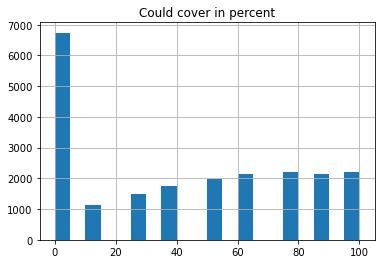

Most of the time it is a clear sky!


In [45]:
print("Show distribution of Cloud Cover")
plt.title('Could cover in percent')
df_weather['CloudCoverPERCENT'].hist(bins=20, range=[0, 100])
plt.show()
print("Most of the time it is a clear sky!")


In [46]:
df_weather['CloudCoverPERCENT'] = df_weather['CloudCoverPERCENT'].astype(
    'category')


Check temperature values for outliers


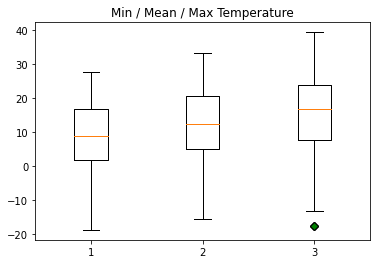

In [47]:
print("Check temperature values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Min / Mean / Max Temperature')
ax1.boxplot([df_weather['MinTemperatureC'], df_weather['MeanTemperatureC'].dropna(
), df_weather['MaxTemperatureC']], flierprops=green_diamond)
plt.show()


Check visibility values for outliers


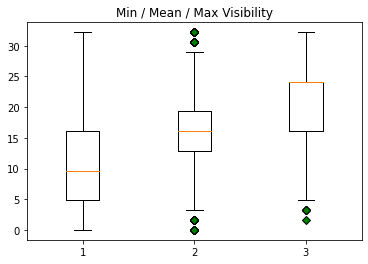

In [48]:
print("Check visibility values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Min / Mean / Max Visibility')
ax1.boxplot([df_weather['MinVisibilityKM'].dropna(), df_weather['MeanVisibilityKM'].dropna(
), df_weather['MaxVisibilityKM'].dropna()], flierprops=green_diamond)
plt.show()


Check humidity values for outliers


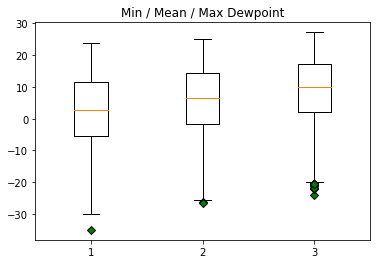

In [49]:
print("Check humidity values for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Min / Mean / Max Dewpoint')
ax1.boxplot([df_weather['MinDewpointC'], df_weather['MeanDewpointC'].dropna(
), df_weather['MaxDewpointC']], flierprops=green_diamond)
plt.show()


Check wind speed for outliers


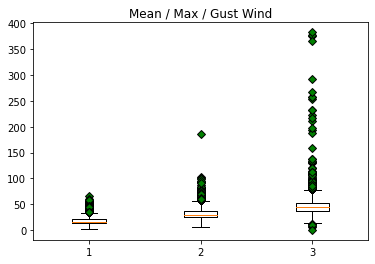

We see very high wind speeds (gusts) up to 375 km/h, which seems too high


In [50]:
print("Check wind speed for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Mean / Max / Gust Wind')
ax1.boxplot([df_weather['MeanWindSpeedKMH'].dropna(), df_weather['MaxWindSpeedKMH'].dropna(
), df_weather['MaxGustSpeedKMH'].dropna()], flierprops=green_diamond)
plt.show()
print("We see very high wind speeds (gusts) up to 375 km/h, which seems too high")


In [51]:
print("Show rows with MaxWind stronger than 100 km/h")
df_weather[df_weather.MaxWindSpeedKMH > 100]


Show rows with MaxWind stronger than 100 km/h


Id       Date  MaxHumidity  MeanHumidity  MinHumidity       Events  \
877      880 1950-11-25          100            89           76  b'Fog-Rain'   
9210    9236 1973-09-18           97            81           55  b'Fog-Rain'   
23910  23977 2014-03-22           76            49           22       b'nan'   

                      city  season  WindDirectionDEG  MaxTemperatureC  ...  \
877    New York City (USA)  Autumn               111        15.000000  ...   
9210   New York City (USA)  Summer               212        23.888889  ...   
23910  New York City (USA)  Spring               266        18.333333  ...   

       MaxVisibilityKM  MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  \
877           16.09344          9.656064       102.998016         65.983104   
9210          24.14016         14.484096       101.388672         22.530816   
23910         16.09344         16.093440       186.683904         22.530816   

       MaxGustSpeedKMH  MaxSeaLevelPressureHPA  MeanSeaLevelPressureHPA  \
877                NaN             1018.287172              1003.387061   
9210               NaN             1020.657645              1013.207589   
23910       292.900608             1017.948533              1012.530311   

       MinSeaLevelPressureHPA  CloudCoverPERCENT  PrecipitationMM  
877                990.180144                0.0              0.0  
9210              1008.805283               75.0             12.7  
23910             1008.128005               50.0              0.0  

[3 rows x 26 columns]

In [52]:
print("Show rows with GustWind stronger than 200 km/h")
df_weather[df_weather.MaxGustSpeedKMH > 200]


Show rows with GustWind stronger than 200 km/h


Id       Date  MaxHumidity  MeanHumidity  MinHumidity  \
21120  21179 2006-08-01           87            67           46   
21146  21205 2006-08-27           93            75           57   
21158  21217 2006-09-08           87            71           54   
21165  21224 2006-09-15           93            90           87   
21245  21304 2006-12-04           70            51           32   
21375  21435 2007-04-13           82            60           38   
21376  21436 2007-04-14           70            50           30   
21427  21487 2007-06-04           93            82           70   
21433  21493 2007-06-10           84            64           44   
21985  22046 2008-12-13           54            45           35   
22163  22225 2009-06-09           93            85           76   
23910  23977 2014-03-22           76            49           22   
23937  24004 2014-04-18           79            64           49   
24447  24515 2015-09-10           93            85           76   

                         Events                 city  season  \
21120                    b'nan'  New York City (USA)  Summer   
21146                   b'Rain'  New York City (USA)  Summer   
21158                    b'nan'  New York City (USA)  Summer   
21165      b'Rain-Thunderstorm'  New York City (USA)  Summer   
21245                    b'nan'  New York City (USA)  Autumn   
21375                    b'nan'  New York City (USA)  Spring   
21376                    b'nan'  New York City (USA)  Spring   
21427      b'Rain-Thunderstorm'  New York City (USA)  Spring   
21433                    b'nan'  New York City (USA)  Spring   
21985                    b'nan'  New York City (USA)  Autumn   
22163  b'Fog-Rain-Thunderstorm'  New York City (USA)  Spring   
23910                    b'nan'  New York City (USA)  Spring   
23937                    b'nan'  New York City (USA)  Spring   
24447      b'Rain-Thunderstorm'  New York City (USA)  Summer   

       WindDirectionDEG  MaxTemperatureC  ...  MaxVisibilityKM  \
21120               235        36.111111  ...         16.09344   
21146               128        23.333333  ...         16.09344   
21158               217        26.666667  ...         16.09344   
21165                49        20.000000  ...         16.09344   
21245               302         6.111111  ...         16.09344   
21375               283        11.111111  ...         16.09344   
21376               270        13.333333  ...         16.09344   
21427                 5        21.666667  ...         16.09344   
21433                52        22.777778  ...         16.09344   
21985               331         1.111111  ...         16.09344   
22163               124        21.111111  ...         16.09344   
23910               266        18.333333  ...         16.09344   
23937               113         7.777778  ...         16.09344   
24447                30        26.111111  ...         16.09344   

       MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  MaxGustSpeedKMH  \
21120         11.265408        35.405568         17.702784       254.276352   
21146         14.484096        37.014912         22.530816       374.977152   
21158         14.484096        28.968192         14.484096       231.745536   
21165         11.265408        41.842944         16.093440       257.495040   
21245         16.093440        46.670976         24.140160       378.195840   
21375         16.093440        56.327040         32.186880       210.824064   
21376         16.093440        41.842944         20.921472       257.495040   
21427          9.656064        45.061632         19.312128       383.023872   
21433         14.484096        19.312128          9.656064       222.089472   
21985         16.093440        41.842944         22.530816       267.151104   
22163         11.265408        32.186880         12.874752       365.321088   
23910         16.093440       186.683904         22.530816       292.900608   
23937         16.093440  

Check wind direction for outliers


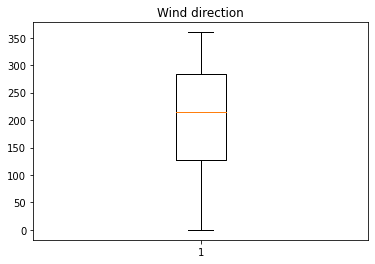

The predominant wind direction is 210° (wind from south-west)


In [53]:
print("Check wind direction for outliers")
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Wind direction')
ax1.boxplot(df_weather['WindDirectionDEG'].dropna(), flierprops=green_diamond)
plt.show()
print("The predominant wind direction is 210° (wind from south-west)")


Show distribution of wind direction


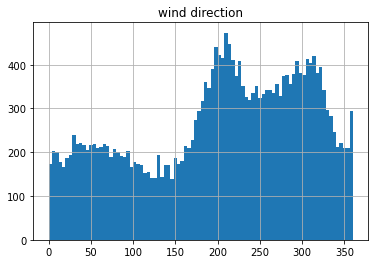

The predominant wind directions are between 200° and 320° (winds from south-west to north-west)


In [54]:
print("Show distribution of wind direction")
plt.title('wind direction')
df_weather['WindDirectionDEG'].hist(bins=90, range=[0, 360])
plt.show()
print("The predominant wind directions are between 200° and 320° (winds from south-west to north-west)")


In [55]:
print("Weather data types after cleaning, renaming and conversion:")
print(f"{df_weather.dtypes}")


Weather data types after cleaning, renaming and conversion:
Id                                  int64
Date                       datetime64[ns]
MaxHumidity                         int64
MeanHumidity                        int64
MinHumidity                         int64
Events                               |S26
city                             category
season                           category
WindDirectionDEG                    int32
MaxTemperatureC                   float64
MeanTemperatureC                  float64
MinTemperatureC                   float64
MaxDewpointC                      float64
MeanDewpointC                     float64
MinDewpointC                      float64
MinVisibilityKM                   float64
MaxVisibilityKM                   float64
MeanVisibilityKM                  float64
MaxWindSpeedKMH                   float64
MeanWindSpeedKMH                  float64
MaxGustSpeedKMH                   float64
MaxSeaLevelPressureHPA            float64
MeanSeaLevelPres

In [56]:
print("Check for missing values in Weather:")
df_weather.isna().sum()


Check for missing values in Weather:


Id                             0
Date                           0
MaxHumidity                    0
MeanHumidity                   0
MinHumidity                    0
Events                         0
city                           0
season                         0
WindDirectionDEG               0
MaxTemperatureC                0
MeanTemperatureC               2
MinTemperatureC                0
MaxDewpointC                   0
MeanDewpointC                  0
MinDewpointC                   0
MinVisibilityKM               15
MaxVisibilityKM               15
MeanVisibilityKM              15
MaxWindSpeedKMH                0
MeanWindSpeedKMH               0
MaxGustSpeedKMH            15538
MaxSeaLevelPressureHPA         0
MeanSeaLevelPressureHPA        0
MinSeaLevelPressureHPA         0
CloudCoverPERCENT           2781
PrecipitationMM              525
dtype: int64

In [57]:
print(f"Show first and last rows of Weather - after cleaning and conversion:")
df_weather.iloc[[0, -1]]


Show first and last rows of Weather - after cleaning and conversion:


Id       Date  MaxHumidity  MeanHumidity  MinHumidity   Events  \
0          1 1948-07-01           93            65           46   b'Fog'   
24559  24627 2015-12-31           93            71           49  b'Rain'   

                      city  season  WindDirectionDEG  MaxTemperatureC  ...  \
0      New York City (USA)  Summer               264        28.888889  ...   
24559  New York City (USA)  Winter               317        11.111111  ...   

       MaxVisibilityKM  MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  \
0             16.09344         11.265408        25.749504         12.874752   
24559         16.09344         16.093440        32.186880         19.312128   

       MaxGustSpeedKMH  MaxSeaLevelPressureHPA  MeanSeaLevelPressureHPA  \
0                  NaN             1018.287172              1016.255339   
24559          40.2336             1019.303089              1017.948533   

       MinSeaLevelPressureHPA  CloudCoverPERCENT  PrecipitationMM  
0                 1015.239422                0.0            0.000  
24559             1016.255339               87.5            1.524  

[2 rows x 26 columns]

# Joining the datasets


In [58]:
df_citibike_weather = pd.merge(
    df_citibike_clean, df_weather, how="left", on="Date")
df_citibike_weather.iloc[[1, -1]]


uniqueid  tripduration           starttime            stoptime  \
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
94294   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id start_station_name  start_station_latitude  \
1                  545    E 23 St & 1 Ave               40.736502   
94294              317  E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  ...  \
1                   -73.978095            415  Pearl St & Hanover Square  ...   
94294               -73.981854            301          E 2 St & Avenue B  ...   

       MaxVisibilityKM  MeanVisibilityKM  MaxWindSpeedKMH MeanWindSpeedKMH  \
1             16.09344          16.09344        46.670976        22.530816   
94294         16.09344          16.09344        46.670976        28.968192   

       MaxGustSpeedKMH MaxSeaLevelPressureHPA MeanSeaLevelPressureHPA  \
1            61.155072            1029.462256             1025.737228   
94294        61.155072            1025.398589             1018.287172   

       MinSeaLevelPressureHPA  CloudCoverPERCENT  PrecipitationMM  
1                 1022.350839               62.5              0.0  
94294             1011.175755               25.0              0.0  

[2 rows x 42 columns]

In [59]:
print(f"Rowcount of citibike dataset: {len(df_citibike_clean)} elements")
print(f"Rowcount of weather dataset: {len(df_weather)} elements")
print(f"Rowcount of joined dataset: {len(df_citibike_weather)} elements\n")

print(
    f"Columncount of citibike dataset: {len(df_citibike_clean.columns)} elements")
print(f"Columncount of weather dataset: {len(df_weather.columns)} elements")
print(
    f"Columncount of joined dataset: {len(df_citibike_weather.columns)} elements")


Rowcount of citibike dataset: 94295 elements
Rowcount of weather dataset: 24560 elements
Rowcount of joined dataset: 94295 elements

Columncount of citibike dataset: 17 elements
Columncount of weather dataset: 26 elements
Columncount of joined dataset: 42 elements


Everything seems fine with the joined dataframe. The Rowcount matches (since we did a left join) and the Columncount matches as well (17 + 26 = 43. Subtract one because of the duplicate Date column -> 42)


# Visualisation final dataset


In [60]:
pd.set_option("display.max_columns", None)


In [61]:
df_citibike_weather.iloc[[1, -1]]


uniqueid  tripduration           starttime            stoptime  \
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
94294   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id start_station_name  start_station_latitude  \
1                  545    E 23 St & 1 Ave               40.736502   
94294              317  E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  \
1                   -73.978095            415  Pearl St & Hanover Square   
94294               -73.981854            301          E 2 St & Avenue B   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
1                 40.704718             -74.009260   19785  Subscriber   
94294             40.722174             -73.983688   19774  Subscriber   

       birth_year gender       Date     Id  MaxHumidity  MeanHumidity  \
1            1957   male 2015-04-13  24365           83            65   
94294        1961   male 2015-11-14  24580           49            40   

       MinHumidity  Events                 city  season  WindDirectionDEG  \
1               47  b'nan'  New York City (USA)  Spring               185   
94294           30  b'nan'  New York City (USA)  Autumn               299   

       MaxTemperatureC  MeanTemperatureC  MinTemperatureC  MaxDewpointC  \
1            16.666667         11.666667         6.111111      7.777778   
94294        10.555556          8.333333         5.555556     -1.666667   

       MeanDewpointC  MinDewpointC  MinVisibilityKM  MaxVisibilityKM  \
1           4.444444      1.666667         16.09344         16.09344   
94294      -4.444444     -6.111111         16.09344         16.09344   

       MeanVisibilityKM  MaxWindSpeedKMH  MeanWindSpeedKMH  MaxGustSpeedKMH  \
1              16.09344        46.670976         22.530816        61.155072   
94294          16.09344        46.670976         28.968192        61.155072   

       MaxSeaLevelPressureHPA  MeanSeaLevelPressureHPA  \
1                 1029.462256              1025.737228   
94294             1025.398589              1018.287172   

       MinSeaLevelPressureHPA CloudCoverPERCENT  PrecipitationMM  
1                 1022.350839              62.5              0.0  
94294             1011.175755              25.0              0.0

In [62]:
print("Number of trips and mean trip duration per start station:")
df_t_s = df_citibike_weather.groupby(
    df_citibike_weather['start_station_id']).size().reset_index(name="nbtrips")
df_td_s = df_citibike_weather.groupby(df_citibike_weather['start_station_id'])[
    'tripduration'].mean().reset_index(name="tripduration")
df_t_td_s = pd.merge(df_t_s, df_td_s, how="inner", on="start_station_id")
df_t_td_s


Number of trips and mean trip duration per start station:


start_station_id  nbtrips  tripduration
0                 72      282    932.801418
1                 79      199    785.256281
2                 82      100    673.020000
3                 83      102    823.137255
4                116      470    573.642553
..               ...      ...           ...
480             3234       66    690.954545
481             3235       58    605.000000
482             3236       51    662.745098
483             3237        2    713.000000
484             3238        2    926.000000

[485 rows x 3 columns]

In [63]:
#df_citibike_weather_extraInformation = df_citibike_weather
#df_citibike_weather_extraInformation['hour'] = df_citibike_weather_extraInformation['starttime'].dt.hour
# df_citibike_weather_extraInformation
# todo
# plot this
df_citibike_weather['starthour'] = df_citibike_weather['starttime'].dt.hour
df_citibike_weather


uniqueid  tripduration           starttime            stoptime  \
0       2018212           146 2015-05-18 13:39:47 2015-05-18 13:42:14   
1       1043212          1542 2015-04-13 08:07:06 2015-04-13 08:32:48   
2       8250156          1414 2015-11-03 16:06:02 2015-11-03 16:29:37   
3       5393550           757 2015-08-25 17:30:52 2015-08-25 17:43:29   
4       7117583          1007 2015-10-06 21:55:52 2015-10-06 22:12:39   
...         ...           ...                 ...                 ...   
94290   1663859           720 2015-05-07 10:46:58 2015-05-07 10:58:58   
94291   6855750          1153 2015-09-29 08:47:37 2015-09-29 09:06:51   
94292   9311608          1098 2015-12-19 08:58:44 2015-12-19 09:17:02   
94293   4681928           438 2015-08-06 17:55:08 2015-08-06 18:02:26   
94294   8672150           418 2015-11-14 15:39:48 2015-11-14 15:46:46   

      start_station_id        start_station_name  start_station_latitude  \
0                  335  Washington Pl & Broadway               40.729039   
1                  545           E 23 St & 1 Ave               40.736502   
2                  401   Allen St & Rivington St               40.720196   
3                 2023   E 55 St & Lexington Ave               40.759681   
4                 3135           E 75 St & 3 Ave               40.771129   
...                ...                       ...                     ...   
94290              496           E 16 St & 5 Ave               40.737262   
94291              400      Pitt St & Stanton St               40.719261   
94292              312   Allen St & E Houston St               40.722055   
94293              461           E 20 St & 2 Ave               40.735877   
94294              317         E 6 St & Avenue B               40.724537   

       start_station_longitude end_station_id           end_station_name  \
0                   -73.994046            439             E 4 St & 2 Ave   
1                   -73.978095            415  Pearl St & Hanover Square   
2                   -73.989978            459           W 20 St & 11 Ave   
3                   -73.970314            533         Broadway & W 39 St   
4                   -73.957723            529            W 42 St & 8 Ave   
...                        ...            ...                        ...   
94290               -73.992390            453            W 22 St & 8 Ave   
94291               -73.981780            466            W 25 St & 6 Ave   
94292               -73.989111            253            W 13 St & 5 Ave   
94293               -73.982050            402         Broadway & E 22 St   
94294               -73.981854            301          E 2 St & Avenue B   

       end_station_latitude  end_station_longitude  bikeid    usertype  \
0                 40.726281             -73.989780   15313  Subscriber   
1                 40.704718             -74.009260   19785  Subscriber   
2                 40.746745             -74.007756   18787  Subscriber   
3                 40.752996             -73.987216   14819  Subscriber   
4                 40.757570             -73.990985   22421  Subscriber   
...                     ...                    ...     ...         ...   
94290             40.744751             -73.999154   16620  Subscriber   
94291             40.743954             -73.991449   14665  Subscriber   
94292             40.735439             -73.994539   18690  Subscriber   
94293             40.740343             -73.989551   14539  Subscriber   
94294             40.722174             -73.983688   19774  Subscriber   

       birth_year  gender       Date     Id  MaxHumidity  MeanHumidity  \
0            1973    male 2015-05-18  24400           90            81   
1            1957    male 2015-04-13  24365           83            65   
2            1973    male 2015-11-03  24569           89            64   
3            1968    male 2015-08-25  24499           85            61   
4            1971    male 2015-10-06  24541  

In [64]:
print("Tripduration per hour:")
df_td_h = df_citibike_weather.groupby('starthour')['tripduration'].mean(
).astype(int).sort_values(ascending=False).to_frame('tripduration')
df_td_h
# todo
# plot this


Tripduration per hour:


tripduration
starthour              
15                  747
14                  745
11                  739
12                  735
18                  734
17                  734
16                  734
13                  732
19                  712
10                  703
20                  702
21                  701
22                  696
23                  690
8                   684
9                   671
1                   665
0                   664
7                   649
4                   626
3                   621
2                   621
6                   598
5                   557

In [65]:
print("Mean triplength per station:")
df_td_s = df_citibike_weather.groupby('start_station_id')['tripduration'].mean(
).astype(int).sort_values(ascending=False).to_frame('tripduration')
df_td_s
# todo
# plot this


Mean triplength per station:


tripduration
start_station_id              
3044                      1549
3016                      1512
3123                      1432
3181                      1309
3130                      1179
...                        ...
3078                       415
262                        413
3070                       322
3059                       246
3049                       147

[485 rows x 1 columns]

In [66]:
print("Mean triplength per weekday:")
# add column weekday
df_citibike_weather['weekday'] = df_citibike_weather['Date'].dt.day_name()
df_td_wd = df_citibike_weather.groupby('weekday')['tripduration'].mean().astype(
    int).sort_values(ascending=False).to_frame('tripduration')
df_td_wd
# todo
# plot this


Mean triplength per weekday:


tripduration
weekday                
Saturday            771
Sunday              765
Friday              703
Monday              703
Thursday            692
Wednesday           689
Tuesday             684

In [67]:
print("Total sum of trips per season:")
df_t_seas_sum = df_citibike_weather.groupby(
    'season')['Id'].size().sort_values(ascending=False).to_frame('trips')
df_t_seas_sum
# todo
# plot this


Total sum of trips per season:


trips
season       
Summer  33003
Autumn  30379
Spring  22423
Winter   8490

In [68]:
print("Total sum of trips per weekday:")
df_t_wd_sum = df_citibike_weather.groupby(
    'weekday')['Id'].size().sort_values(ascending=False).to_frame('trips')
df_t_wd_sum
# todo
# plot this


Total sum of trips per weekday:


trips
weekday         
Wednesday  15222
Tuesday    14579
Thursday   14509
Friday     14504
Monday     14173
Saturday   10766
Sunday     10542

In [69]:
px.scatter(df_citibike_weather, x="tripduration",
           y="MeanTemperatureC", color="season")


In [70]:
tmp = df_citibike_weather.groupby(["season", "gender"]).count().reset_index()
px.bar(tmp, x="season", y="uniqueid", color="gender", color_discrete_map={'female': '#f25e70',
                                                                          'male': '#73c0f0',
                                                                          'undefined': '#8ff296'})


In [71]:
fig_1 = make_subplots(rows=1, cols=2, specs=[
                      [{'type': 'domain'}, {'type': 'domain'}]])

labels = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Summer"]["gender"].value_counts().index
values = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Summer"]["gender"].value_counts().values
fig_1.add_trace(go.Pie(labels=labels, values=values), row=1, col=1)

labels = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Winter"]["gender"].value_counts().index
values = df_citibike_weather.loc[df_citibike_weather['season']
                                 == "Winter"]["gender"].value_counts().values
fig_1.add_trace(go.Pie(labels=labels, values=values), row=1, col=2)

fig_1.update_traces(hole=.4, hoverinfo="label+percent+name")
fig_1.update_traces(marker=dict(colors=['#f25e70', '#8ff296', '#73c0f0']))

fig_1.update_layout(
    title_text="Usage of Bikes per gender in Winter and Summer",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Summer', x=0.175, y=0.5, font_size=20, showarrow=False),
                 dict(text='Winter', x=0.82, y=0.5, font_size=20, showarrow=False)])

fig_1.show()


In [72]:
### Superseded by the next graph ###

df_citibike_weather_grouped = df_citibike_weather.groupby(
    ["birth_year", "season"]).count().reset_index()

# fig_2 = go.Figure(go.Heatmap(x = df_citibike_weather_grouped["season"], y = df_citibike_weather_grouped["birth_year"], z = df_citibike_weather_grouped["tripduration"], type = "heatmap", colorscale = "Blues"))
# # fig_2.update_yaxes(categoryorder="array", categoryarray=["<15" ,"15-20", "20-25", "25-30", "30-35", "35-40", "40-45", ">=45"][::-1])
# fig_2.update_layout(
#     title_text = 'Age Demographic per birth year and season',
# )
# fig_2.show()


In [73]:
fig_dropdown = go.Figure()
fig_dropdown.add_trace(go.Heatmap(x=df_citibike_weather_grouped["season"], y=df_citibike_weather_grouped[
                       "birth_year"], z=df_citibike_weather_grouped["tripduration"], type="heatmap", colorscale="Reds"))

# Add dropdowns
button_layer_1_height = 1.08
fig_dropdown.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=["colorscale", "Reds"],
                    label="Reds",
                    method="restyle"
                ),
                dict(
                    args=["colorscale", "Blues"],
                    label="Blues",
                    method="restyle"
                ),
                dict(
                    args=["colorscale", "Viridis"],
                    label="Viridis",
                    method="restyle"
                ),
                dict(
                    args=["colorscale", "Cividis"],
                    label="Cividis",
                    method="restyle"
                ),
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
        dict(
            buttons=list([
                dict(
                    args=["reversescale", False],
                    label="False",
                    method="restyle"
                ),
                dict(
                    args=["reversescale", True],
                    label="True",
                    method="restyle"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.37,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
        dict(
            buttons=list([
                dict(
                    args=[{"type": "heatmap"}],
                    label="Heatmap",
                    method="restyle"
                ),
                dict(
                    args=[{"contours.showlines": False, "type": "contour"}],
                    label="Hide lines",
                    method="restyle"
                ),
                dict(
                    args=[{"contours.showlines": True, "type": "contour"}],
                    label="Show lines",
                    method="restyle"
                ),
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.58,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        ),
    ]
)

# Update plot sizing
fig_dropdown.update_layout(
    width=1000,
    height=800,
    autosize=False,
    margin=dict(t=150, b=0, l=0, r=0),
)

fig_dropdown.update_layout(
    annotations=[
        dict(text="colorscale", x=0, xref="paper", y=1.06, yref="paper",
             align="left", showarrow=False),
        dict(text="Reverse<br>Colorscale", x=0.25, xref="paper", y=1.07,
             yref="paper", showarrow=False),
        dict(text="Lines", x=0.54, xref="paper", y=1.06, yref="paper",
             showarrow=False)
    ])

fig_dropdown.update_xaxes(categoryorder="array", categoryarray=[
                          "Spring", "Summer", "Autumn", "Winter"])
fig_dropdown.update_layout(
    title_text='Age Demographic per birth year and season',
)

fig_dropdown.show()


In [74]:
# read the neighborhood population data into a DataFrame and load the GeoJSON data
df_population = pd.read_csv(
    'data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
df_population.iloc[[1, -1]]


Borough  Year  FIPS County Code NTA Code  \
1            Bronx  2000                 5     BX03   
389  Staten Island  2010                85     SI99   

                            NTA Name  Population  
1    Eastchester-Edenwald-Baychester       35422  
389  park-cemetery-etc-Staten Island           0

In [75]:
print("Rename columns to avoid whitespace in the names")
df_population.columns = df_population.columns.str.replace('\s', '', regex=True)
df_population.iloc[[1, -1]]


Rename columns to avoid whitespace in the names


Borough  Year  FIPSCountyCode NTACode  \
1            Bronx  2000               5    BX03   
389  Staten Island  2010              85    SI99   

                             NTAName  Population  
1    Eastchester-Edenwald-Baychester       35422  
389  park-cemetery-etc-Staten Island           0

In [76]:
# read the NYC neighborhoods GeoJSON data
nycmap = json.load(open("data/nyc_neighborhoods.geojson"))


# call Plotly Express choropleth function to visualize data
fig = px.choropleth_mapbox(df_population,
                           geojson=nycmap,
                           locations="NTACode",
                           featureidkey="properties.ntacode",
                           color="Population",
                           color_continuous_scale="viridis",
                           mapbox_style="carto-positron",
                           zoom=10, center={"lat": 40.75, "lon": -73.96},
                           opacity=0.5,
                           width=800,
                           hover_name="NTAName",
                           hover_data=["NTAName", "Population"]
                           )

for i in range(100):
    fig.add_trace(go.Scattermapbox(mode="markers+lines",
                                   lat=[df_citibike_weather.iloc[i]["start_station_latitude"],
                                        df_citibike_weather.iloc[i]["end_station_latitude"]],
                                   lon=[df_citibike_weather.iloc[i]["start_station_longitude"],
                                        df_citibike_weather.iloc[i]["end_station_longitude"]],
                                   marker={"size": 2}, line=dict(width=1)))

# fig.add_trace(go.Scattermapbox(mode="markers+lines", lat=[40.736502, 40.704718], lon=[-73.978095, -74.009260], marker = {"size": 2}))

fig.show()


# Correlation


In [77]:
correlation_matrix = df_citibike_weather.corr().unstack(
).sort_values(ascending=False)  # Build correlation matrix
correlation_matrix = pd.DataFrame(
    correlation_matrix).reset_index()  # Convert to dataframe
correlation_matrix.columns = ['explained_variable',
                              'explanatory_variable', 'correlation']  # Label it


In [78]:
print("show positive correlations:")
correlation_matrix[(correlation_matrix['correlation'] < 1) & (
    correlation_matrix['correlation'] > 0.3)].sort_values(by='correlation', ascending=False)
# todo
# plot this


show positive correlations:


explained_variable explanatory_variable  correlation
30    MeanTemperatureC      MaxTemperatureC     0.989146
31     MaxTemperatureC     MeanTemperatureC     0.989146
32    MeanTemperatureC      MinTemperatureC     0.988781
33     MinTemperatureC     MeanTemperatureC     0.988781
34            uniqueid                   Id     0.986857
..                 ...                  ...          ...
111           uniqueid               bikeid     0.337915
112             bikeid                   Id     0.331711
113                 Id               bikeid     0.331711
114    MinTemperatureC          MaxHumidity     0.305402
115        MaxHumidity      MinTemperatureC     0.305402

[86 rows x 3 columns]

In [79]:
print("show nagative correlations:")
correlation_matrix[(correlation_matrix['correlation'] > -1) & (
    correlation_matrix['correlation'] < -0.3)].sort_values(by='correlation', ascending=True)
# todo
# plot this


show nagative correlations:


explained_variable     explanatory_variable  correlation
899          MinVisibilityKM             MeanHumidity    -0.624238
898             MeanHumidity          MinVisibilityKM    -0.624238
896          MinVisibilityKM              MaxHumidity    -0.603792
897              MaxHumidity          MinVisibilityKM    -0.603792
895             MeanHumidity         MeanVisibilityKM    -0.565371
894         MeanVisibilityKM             MeanHumidity    -0.565371
893              MinHumidity         MeanVisibilityKM    -0.530039
892         MeanVisibilityKM              MinHumidity    -0.530039
891          MinVisibilityKM              MinHumidity    -0.524628
890              MinHumidity          MinVisibilityKM    -0.524628
889   MaxSeaLevelPressureHPA          MinTemperatureC    -0.519612
888          MinTemperatureC   MaxSeaLevelPressureHPA    -0.519612
887         MeanTemperatureC   MaxSeaLevelPressureHPA    -0.504349
886   MaxSeaLevelPressureHPA         MeanTemperatureC    -0.504349
884             MaxDewpointC   MaxSeaLevelPressureHPA    -0.477592
885   MaxSeaLevelPressureHPA             MaxDewpointC    -0.477592
883          MaxTemperatureC   MaxSeaLevelPressureHPA    -0.476658
882   MaxSeaLevelPressureHPA          MaxTemperatureC    -0.476658
881              MaxHumidity         MeanVisibilityKM    -0.474709
880         MeanVisibilityKM              MaxHumidity    -0.474709
879          PrecipitationMM          MinVisibilityKM    -0.473120
878          MinVisibilityKM          PrecipitationMM    -0.473120
877   MaxSeaLevelPressureHPA            MeanDewpointC    -0.461276
876            MeanDewpointC   MaxSeaLevelPressureHPA    -0.461276
875             MinDewpointC   MaxSeaLevelPressureHPA    -0.417691
874   MaxSeaLevelPressureHPA             MinDewpointC    -0.417691
873   MinSeaLevelPressureHPA          MaxWindSpeedKMH    -0.415646
872          MaxWindSpeedKMH   MinSeaLevelPressureHPA    -0.415646
871              MinHumidity         WindDirectionDEG    -0.407015
870         WindDirectionDEG              MinHumidity    -0.407015
869             MeanHumidity         WindDirectionDEG    -0.402108
868         WindDirectionDEG             MeanHumidity    -0.402108
867          MinTemperatureC  MeanSeaLevelPressureHPA    -0.392860
866  MeanSeaLevelPressureHPA          MinTemperatureC    -0.392860
865             MaxDewpointC  MeanSeaLevelPressureHPA    -0.381025
864  MeanSeaLevelPressureHPA             MaxDewpointC    -0.381025
863  MeanSeaLevelPressureHPA         MeanTemperatureC    -0.373552
862         MeanTemperatureC  MeanSeaLevelPressureHPA    -0.373552
861          PrecipitationMM         MeanVisibilityKM    -0.360258
860         MeanVisibilityKM          PrecipitationMM    -0.360258
859            MeanDewpointC  MeanSeaLevelPressureHPA    -0.348952
858  MeanSeaLevelPressureHPA            MeanDewpointC    -0.348952
856  MeanSeaLevelPressureHPA          MaxTemperatureC    -0.344432
857          MaxTemperatureC  MeanSeaLevelPressureHPA    -0.344432
855   MinSeaLevelPressureHPA         MeanWindSpeedKMH    -0.339789
854         MeanWindSpeedKMH   MinSeaLevelPressureHPA    -0.339789
853             MinDewpointC         MeanWindSpeedKMH    -0.339264
852         MeanWindSpeedKMH             MinDewpointC    -0.339264
851              MaxHumidity         MeanWindSpeedKMH    -0.324745
850         MeanWindSpeedKMH              MaxHumidity    -0.324745
849          MaxWindSpeedKMH  MeanSeaLevelPressureHPA    -0.323157
848  MeanSeaLevelPressureHPA          MaxWindSpeedKMH    -0.323157
847            MeanDewpointC         MeanWindSpeedKMH    -0.310174
846         MeanWindSpeedKMH            MeanDewpointC    -0.310174
845              MaxHumidity         WindDirectionDEG    -0.300378
844         WindDirectionDEG              MaxHumidity    -0.300378

In [80]:
print("Correlation of tripduration with other columns")
correlation_matrix.query(
    "explained_variable == 'tripduration' & explanatory_variable != 'tripduration'")  # Filter by variable
# todo
# plot this


Correlation of tripduration with other columns


explained_variable     explanatory_variable  correlation
214       tripduration          MaxTemperatureC     0.100038
227       tripduration         MeanTemperatureC     0.096069
229       tripduration          MinTemperatureC     0.090292
232       tripduration             MaxDewpointC     0.082140
235       tripduration            MeanDewpointC     0.081681
238       tripduration             MinDewpointC     0.079781
281       tripduration                starthour     0.045511
360       tripduration          MinVisibilityKM     0.023837
373       tripduration              MaxHumidity     0.019781
377       tripduration         MeanVisibilityKM     0.018006
391       tripduration                       Id     0.014691
420       tripduration   MinSeaLevelPressureHPA     0.008097
456       tripduration                   bikeid     0.002511
464       tripduration                 uniqueid     0.000936
482       tripduration             MeanHumidity    -0.000549
489       tripduration          MaxVisibilityKM    -0.001149
542       tripduration   start_station_latitude    -0.009072
549       tripduration  MeanSeaLevelPressureHPA    -0.009371
551       tripduration         WindDirectionDEG    -0.009696
572       tripduration  start_station_longitude    -0.015677
574       tripduration              MinHumidity    -0.016184
579       tripduration    end_station_longitude    -0.018168
584       tripduration     end_station_latitude    -0.019702
607       tripduration          MaxGustSpeedKMH    -0.026334
611       tripduration   MaxSeaLevelPressureHPA    -0.028596
629       tripduration          PrecipitationMM    -0.032718
651       tripduration          MaxWindSpeedKMH    -0.037726
657       tripduration         MeanWindSpeedKMH    -0.041573
660       tripduration               birth_year    -0.045342

In [81]:
# present the correlation matrix visually
#import seaborn as sn
#sn.heatmap(correlation_matrix, annot=True)
# plt.show()
# TODO
# warum geht das nicht?

# Use this instead.
corr_plot = df_citibike_weather.corr()
# corr_plot.style.background_gradient(cmap='coolwarm')
corr_plot.style.background_gradient(cmap='coolwarm')


In [82]:
corr_plot.style.background_gradient(cmap='coolwarm').to_html(
    os.path.join(results_pathname, "correlation_matrix_plot.html"))


# Clustering


In [83]:
# Takes too long to leave it uncommented (look into the results folder)
# pairplot = sns.pairplot(df_citibike_weather)

# Saving it does not work now ...
# fig = pairplot.get_figure()
# fig.safefig(os.path.join(results_pathname, "pairplot.png"))


In [84]:
from sklearn.cluster import KMeans


### Clustering tripduration and temperature


In [85]:
df_td_T = df_citibike_weather[['tripduration', 'MeanTemperatureC']]
df_td_T


tripduration  MeanTemperatureC
0               146         17.222222
1              1542         11.666667
2              1414         14.444444
3               757         26.666667
4              1007         17.222222
...             ...               ...
94290           720         16.666667
94291          1153         23.888889
94292          1098          3.888889
94293           438         25.555556
94294           418          8.333333

[94295 rows x 2 columns]

In [86]:
kmeans = KMeans(n_clusters=3).fit(df_td_T)


In [87]:
centroids = kmeans.cluster_centers_
print(centroids)


[[ 832.66648284   17.80064808]
 [1483.60002518   18.6929092 ]
 [ 374.63392388   16.74604843]]


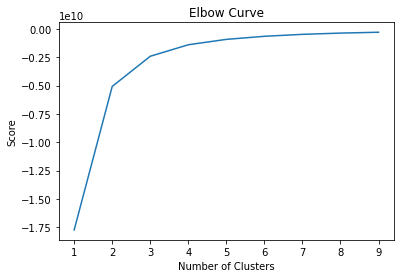

In [88]:
K_clusters = range(1, 10)
kmeans2 = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df_td_T[['tripduration']]
X_axis = df_td_T[['MeanTemperatureC']]

score = [kmeans2[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans2))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


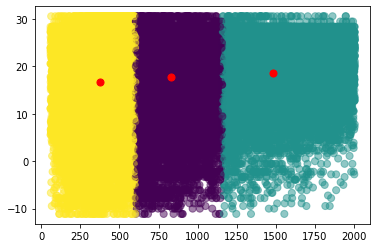

In [89]:
# scatterplot of trip duration and temperature
plt.scatter(df_td_T['tripduration'], df_td_T['MeanTemperatureC'],
            c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()
# red=cluster centers, violett=cluster 1, yellow=cluster 2


### Clustering number of trips and station id


In [90]:
df_t_s

start_station_id  nbtrips
0                 72      282
1                 79      199
2                 82      100
3                 83      102
4                116      470
..               ...      ...
480             3234       66
481             3235       58
482             3236       51
483             3237        2
484             3238        2

[485 rows x 2 columns]

In [91]:
# use 4 Clusters
kmeans = KMeans(n_clusters=4).fit(df_t_s)
centroids = kmeans.cluster_centers_
print(centroids)


[[3121.18831169   37.88961039]
 [ 331.35638298  152.5106383 ]
 [2009.53333333  182.86666667]
 [ 416.859375    445.6640625 ]]


c:\home\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



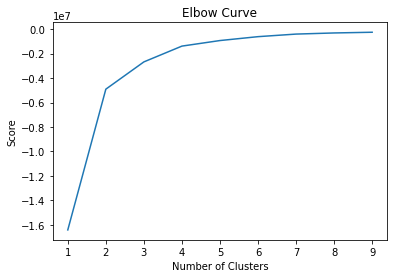

In [92]:
K_clusters = range(1, 10)
kmeans2 = [KMeans(n_clusters=i) for i in K_clusters]

X_axis = df_t_s[['start_station_id']]
Y_axis = df_t_s[['nbtrips']]

score = [kmeans2[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans2))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

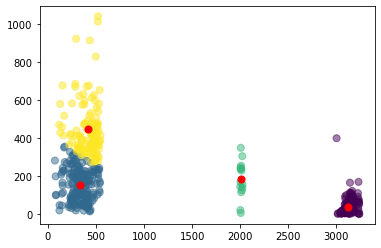

In [93]:
# scatterplot of stationid and number of trips
plt.scatter(df_t_s['start_station_id'], df_t_s['nbtrips'],
            c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()
# red=cluster centers, violett=cluster 1, yellow=cluster 2. blue=cluster 3, green=cluster 4

### Clustering of Latitude and Longitude


In [94]:
# Out of memory because o(n^2) complexity (for hierarchical clustering)

# plt.figure(figsize=(10, 7))
# plt.title("Dendrogram Latidude / Longitude")

selected_data = df_citibike_weather[[
    "start_station_latitude", "start_station_longitude"]]
# clusters = shc.linkage(selected_data,
#             method='ward',
#             metric="euclidean")
# shc.dendrogram(Z=clusters)
# plt.show()


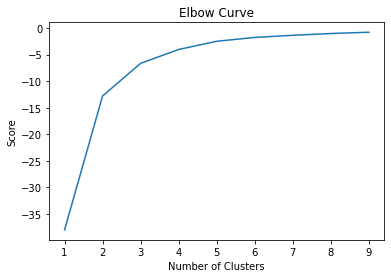

In [95]:
K_clusters = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = selected_data[['start_station_latitude']]
X_axis = selected_data[['start_station_longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [96]:
kmeans = KMeans(n_clusters=3).fit(selected_data)


In [97]:
centroids = kmeans.cluster_centers_
print(centroids)


[[ 40.7547787  -73.98335202]
 [ 40.72735902 -73.99760408]
 [ 40.70205146 -73.97292647]]


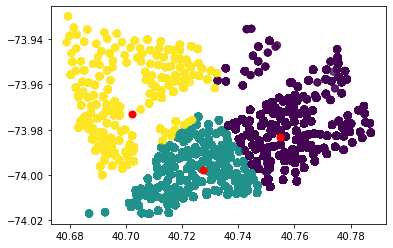

In [98]:
# scatterplot of trip duration and temperature
plt.scatter(selected_data['start_station_latitude'],
            selected_data['start_station_longitude'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()


### Silhouette Plots

In [99]:
# # Calculate Silhoutte Score
# #
# score = silhouette_score(selected_data, kmeans.labels_, metric='euclidean')
# #
# # Print the score
# #
# print('Silhouetter Score: %.3f' % score)

Run with 2 clusters started.
Run with 3 clusters started.
Run with 4 clusters started.
Run with 5 clusters started.


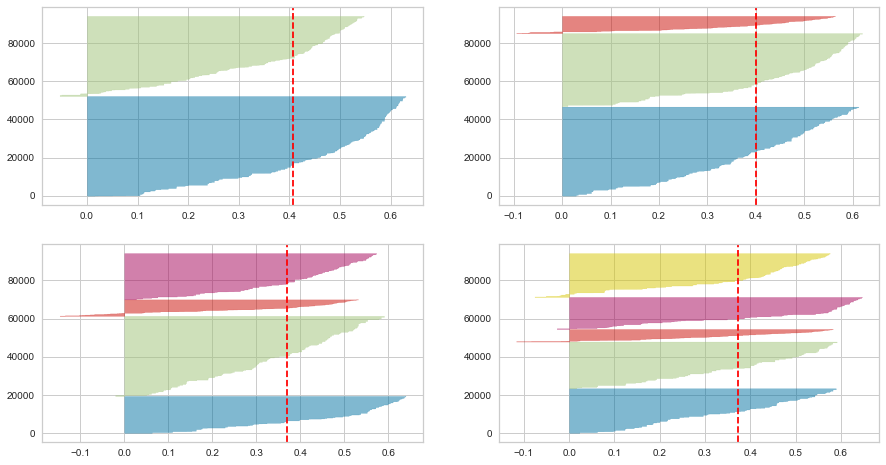

In [100]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    print(f"Run with {i} clusters started.")
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(selected_data)

### other clustering methods

In [101]:
# MeanShift uses just one cluster

# clustering = MeanShift(min_bin_freq=1000, bin_seeding=True,
#                        n_jobs=-1, max_iter=100).fit(selected_data)



In [102]:
# labels = clustering.labels_
# cluster_centers = clustering.cluster_centers_
# print(cluster_centers)
# n_clusters_ = len(np.unique(labels))

# print("Estimated clusters:", n_clusters_)
# colors = 10*['r.', 'g.', 'b.', 'c.', 'k.', 'y.', 'm.']
# for i in range(len(selected_data)):
#     plt.plot(selected_data.iloc[i][0], selected_data.iloc[i]
#              [1], colors[labels[i]], markersize=3)

# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
#                 marker=".", color='k', s=20, linewidths=5, zorder=10)
# plt.show()


In [103]:
# Does not function with new scikit learn versions

# clustering = Birch(n_clusters=3).fit(selected_data)

In [104]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(selected_data)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 185206.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 185004.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 185056.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 185484.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 184586.0
Best run was number 5
[[ 40.751873   -73.977706  ]
 [ 40.73492695 -73.99200509]
 [ 40.76019252 -73.9912551 ]]
